#  Projet Machine Learning

### Arthur Frachon - Jeanne Collot

## Sujet

## 1) Problématique 

## 2) Préparation des données

In [100]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
warnings.filterwarnings("ignore")

In [101]:
# Charger les fichiers CSV
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
X_test = pd.read_csv('X_test.csv', index_col=0)

# Fusionner les cibles avec les features pour exploration
train_data = pd.concat([X_train, y_train], axis=1)

# Vérification des structures des fichiers
print("Structure de nos fichiers : \n")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("\n")

# Exploration initiale des données
print("Informations sur notre dataset : \n")
print(train_data.info())
print("\n --------------------------- \n Informations sur nos features : \n")
print(train_data.describe())

Structure de nos fichiers : 

X_train shape: (10605, 9)
y_train shape: (10605, 1)
X_test shape: (4942, 9)


Informations sur notre dataset : 

<class 'pandas.core.frame.DataFrame'>
Index: 10605 entries, 2022-01-01 02:00:00+01:00 to 2023-03-29 23:00:00+02:00
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   load_forecast                  9318 non-null   float64
 1   coal_power_available           10604 non-null  float64
 2   gas_power_available            10604 non-null  float64
 3   nucelear_power_available       10604 non-null  float64
 4   wind_power_forecasts_average   10581 non-null  float64
 5   solar_power_forecasts_average  10581 non-null  float64
 6   wind_power_forecasts_std       10581 non-null  float64
 7   solar_power_forecasts_std      10581 non-null  float64
 8   predicted_spot_price           1846 non-null   float64
 9   spot_id_delta                  10605 non-nul

## 3) Traitement et création de nouvelles features (A completer)

### 3.1) Normalisation des données

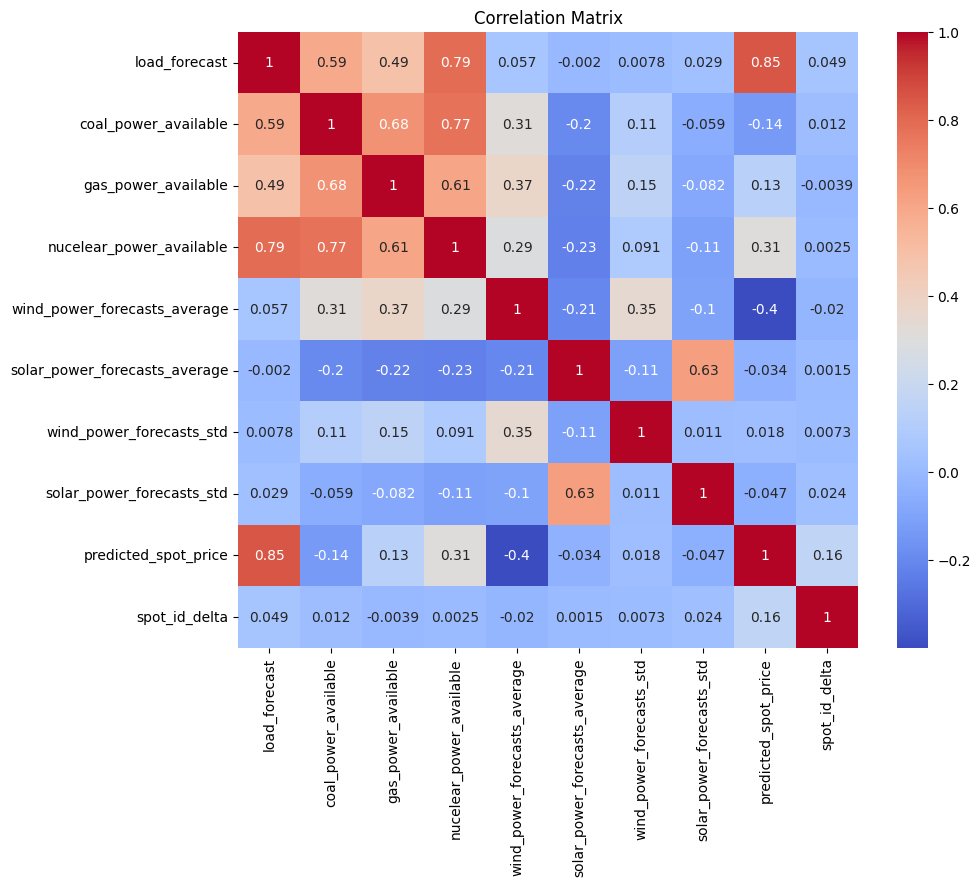

In [102]:
# Vérifier la corrélation entre les features et la cible
corr_matrix = train_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

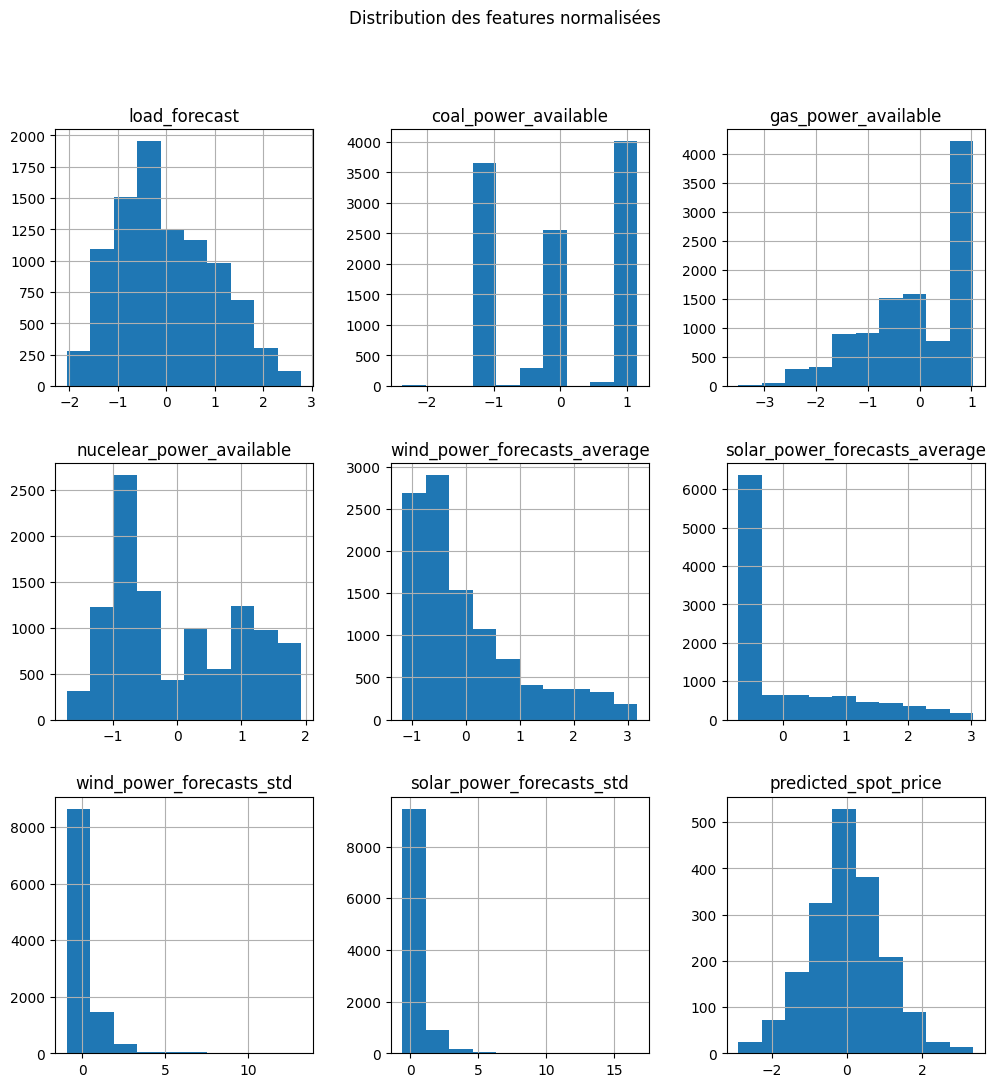

In [103]:
# Normalisation des features numériques
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns,index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns,index=X_test.index)

# Vérifier les distributions des features
X_train_scaled.hist(figsize=(12, 12))
plt.suptitle("Distribution des features normalisées")
plt.show()

### 3.2) Méthode 1 - remplissage des valeurs manquantes par la moyenne de la colonne

In [104]:
X_train_1 = X_train_scaled.fillna(X_train_scaled.mean())
print(X_train_1.info())
print(X_train_1.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 10605 entries, 2022-01-01 02:00:00+01:00 to 2023-03-29 23:00:00+02:00
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   load_forecast                  10605 non-null  float64
 1   coal_power_available           10605 non-null  float64
 2   gas_power_available            10605 non-null  float64
 3   nucelear_power_available       10605 non-null  float64
 4   wind_power_forecasts_average   10605 non-null  float64
 5   solar_power_forecasts_average  10605 non-null  float64
 6   wind_power_forecasts_std       10605 non-null  float64
 7   solar_power_forecasts_std      10605 non-null  float64
 8   predicted_spot_price           10605 non-null  float64
dtypes: float64(9)
memory usage: 1.1+ MB
None
       load_forecast  coal_power_available  gas_power_available  \
count   1.060500e+04          1.060500e+04         1.060500e+04   
mean   -2.894

In [105]:
X_test_1 = X_test_scaled.fillna(X_test_scaled.mean())
y_train_1 = y_train.copy()

### 3.3) Methode 2 - Calcul des spots prices

Dans un second temps nous testons la 2ème méthode, pour cela nous devons prédire le plus précisemment possible les valeurs spots de l'éléctricité à partir des autres features et des quelques valeurs tests dont nous disposons, nous essaierons plusieurs modèles et garderont celui qui maximise le R².
Nous sommes conscients que cette technique peut ammener à cumuler les erreurs.

Repartons de nos données

#### Traitement des données

In [106]:
# division en set de train et set de test en fonction de si la valeur spot est fournie
data_test = X_train_scaled[X_train_scaled['predicted_spot_price'].isnull()]
data_train = X_train_scaled[~X_train_scaled['predicted_spot_price'].isnull()]
data_train

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
DELIVERY_START,,,,,,,,,
2023-01-03 01:00:00+01:00,-0.483443,1.14369,0.995872,0.918269,-0.215268,-0.709050,-0.460626,-0.580229,-0.748258
2023-01-03 02:00:00+01:00,-0.541011,1.14369,0.995872,0.918269,-0.143312,-0.709050,-0.289021,-0.580229,-0.873872
2023-01-03 03:00:00+01:00,-0.716465,1.14369,0.995872,0.918269,-0.093450,-0.709050,-0.432307,-0.580229,-1.030446
2023-01-03 04:00:00+01:00,-0.776428,1.14369,0.995872,0.918269,-0.045679,-0.709050,-0.494938,-0.580229,-1.335930
2023-01-03 05:00:00+01:00,-0.563541,1.14369,0.995872,0.918269,-0.005371,-0.709050,-0.577213,-0.580229,-1.251303
...,...,...,...,...,...,...,...,...,...
2023-03-29 19:00:00+02:00,-0.258226,1.14369,1.010342,0.384111,0.907367,-0.468548,0.923286,-0.398677,-0.947883
2023-03-29 20:00:00+02:00,-0.274725,1.14369,1.010342,0.384111,1.142046,-0.668781,0.230014,-0.521409,-0.430390
2023-03-29 21:00:00+02:00,-0.490007,1.14369,1.010342,0.384111,1.374038,-0.709050,0.011239,-0.580229,-0.066228


In [107]:
# Traitement
## Missing Data
data_train= data_train.dropna(axis=1, thresh=len(data_train)*0.25)
data_train = data_train.dropna()

## Target
X_fill = data_train[[col for col in data_train.columns if col !='predicted_spot_price']]
y_fill = data_train[['predicted_spot_price']]
X_fill_reste = data_test[[col for col in data_train.columns if col !='predicted_spot_price']]
y_fill_reste = data_test[['predicted_spot_price']]
## Format
X_fill= pd.get_dummies(X_fill)
## Split
X_fill_train, X_fill_test, y_fill_train, y_fill_test = sk.model_selection.train_test_split(X_fill, y_fill, test_size=0.2, random_state=42)

#### Sélection de modèles 

In [108]:
models = {
    'XGBoost' : XGBRegressor(),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Support Vector Regression': SVR(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'Gradient Boosting Regression': GradientBoostingRegressor(),
    'K-Neighbors Regression': KNeighborsRegressor()}

res = list()
for mod in models.values() :
    print(f"Model: {mod.__class__.__name__}")
    # Initialiser le modèle
    model = mod
    # Entraîner le modèle de base
    model.fit(X_fill_train, y_fill_train)
    # Évaluation du modèle
    y_pred = model.predict(X_fill_test)
    mse = mean_squared_error(y_fill_test, y_pred)
    r2 = r2_score(y_fill_test, y_pred)    
    # Validation croisée
    cv_scores = sk.model_selection.cross_val_score(model, X_fill_train, y_fill_train, cv=10, scoring='neg_mean_squared_error')
    res.append([mod.__class__.__name__,mse,r2,cv_scores])

Model: XGBRegressor
Model: LinearRegression
Model: Ridge
Model: Lasso
Model: ElasticNet
Model: SVR
Model: DecisionTreeRegressor
Model: RandomForestRegressor
Model: GradientBoostingRegressor
Model: KNeighborsRegressor


In [109]:
res = pd.DataFrame(res,columns=["model","mse","r2","cv_score"]).sort_values(by="r2",ascending=False)
res["cv_mean"] = res['cv_score'].apply(lambda x : np.mean(x))
res.head(1)

,model,mse,r2,cv_score,cv_mean
0,XGBRegressor,0.152599,0.857077,"[-0.1466173117606055, -0.12326569393439539, -0...",-0.164013


On choisira donc un modèle XGBoost car c'est celui qui maximise le R²

Optimisons les paramètres du modèle afin d'essayer d'améliorer encore plus la prédiction de nos données

In [110]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2,0.3],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.2,0.4,0.6, 0.8, 1.0],
    'colsample_bytree': [0.2,0.4,0.6, 0.8, 1.0]
}

grid_search = sk.model_selection.GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_fill_train, y_fill_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


In [111]:
y_pred_best = best_model.predict(X_fill_test)
best_mse = mean_squared_error(y_fill_test, y_pred_best)
best_r2 = r2_score(y_fill_test, y_pred_best)

print(f"Best Mean Squared Error: {best_mse}")
print(f"Best R^2 Score: {best_r2}")

best_cv_scores = sk.model_selection.cross_val_score(best_model, X_fill_train, y_fill_train, cv=5, scoring='neg_mean_squared_error')
print(f"Best Cross-Validation Scores (neg MSE): {best_cv_scores}")
print(f"Mean Best Cross-Validation Score (neg MSE): {best_cv_scores.mean()}")

Best Mean Squared Error: 0.1433769146674095
Best R^2 Score: 0.8657135849020686
Best Cross-Validation Scores (neg MSE): [-0.13175667 -0.14489983 -0.15465877 -0.1716862  -0.16604642]
Mean Best Cross-Validation Score (neg MSE): -0.15380957757966945


Hyperparamètres optimaux :

In [112]:
best_params

{'colsample_bytree': 1.0,
 'learning_rate': 0.3,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 1.0}

#### Remplissage des valeurs manquantes pour X_train

In [113]:
X_fill_reste = pd.get_dummies(X_fill_reste)
y_fill_reste = best_model.predict(X_fill_reste)
# on rassemble tout
X_fill_reste['predicted_spot_price'] = y_fill_reste
X_train_2 = pd.concat([data_train,X_fill_reste]).sort_index()
#data_filled.to_csv("X_train_filled.csv")
X_train_2

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
DELIVERY_START,,,,,,,,,
2022-01-01 02:00:00+01:00,-0.380192,1.14369,0.049154,1.145057,-0.441288,-0.709050,-0.349241,-0.580229,-0.812971
2022-01-01 03:00:00+01:00,-0.639914,1.14369,0.049154,1.145057,-0.409042,-0.709050,-0.481457,-0.580229,-1.077500
2022-01-01 04:00:00+01:00,-0.759929,1.14369,0.049154,1.145057,-0.365749,-0.709050,-0.613775,-0.580229,-1.864054
2022-01-01 05:00:00+01:00,-0.793548,1.14369,0.049154,1.145057,-0.318276,-0.709050,-0.675551,-0.580229,-1.974364
2022-01-01 06:00:00+01:00,-0.748753,1.14369,0.049154,1.145057,-0.249007,-0.709050,-0.714482,-0.580229,-1.964257
...,...,...,...,...,...,...,...,...,...
2023-03-29 19:00:00+02:00,-0.258226,1.14369,1.010342,0.384111,0.907367,-0.468548,0.923286,-0.398677,-0.947883
2023-03-29 20:00:00+02:00,-0.274725,1.14369,1.010342,0.384111,1.142046,-0.668781,0.230014,-0.521409,-0.430390
2023-03-29 21:00:00+02:00,-0.490007,1.14369,1.010342,0.384111,1.374038,-0.709050,0.011239,-0.580229,-0.066228


In [114]:
y_train_2 = y_train.loc[X_train_2.index]
y_train_2

,spot_id_delta
DELIVERY_START,
2022-01-01 02:00:00+01:00,-36.874770
2022-01-01 03:00:00+01:00,-12.643588
2022-01-01 04:00:00+01:00,-1.950193
2022-01-01 05:00:00+01:00,1.938272
2022-01-01 06:00:00+01:00,0.199907
...,...
2023-03-29 19:00:00+02:00,6.029303
2023-03-29 20:00:00+02:00,13.576177
2023-03-29 21:00:00+02:00,17.478945


#### Remplissage pour X_test

In [ ]:
data_fill = X_test_scaled[X_test_scaled['predicted_spot_price'].isnull()]
data_keep = X_test_scaled[~X_test_scaled['predicted_spot_price'].isnull()]

In [16]:
X_test_test = data_fill[[col for col in data_fill.columns if col !='predicted_spot_price']]
X_test_test = pd.get_dummies(X_test_test)
y_test_test = best_model.predict(X_test_test)

In [17]:
X_test_test['predicted_spot_price'] = y_test_test
X_test_2 = pd.concat([data_keep,X_test_test]).sort_index()
#X_test_2.to_csv("X_train_filled.csv")

### 3.4) Methode 3 - Supprimer les lignes spot avec les valeurs manquantes 

On remplira les valeurs manquantes des colonnes par leur moyenne.

In [73]:
#X_train_3 = X_train.dropna(axis=0)
#X_test_3 =  X_test.dropna(axis=0)
X_train_3 = X_train_scaled.dropna(subset=['predicted_spot_price'],axis=0)
X_train_3 = X_train_3.fillna(X_train_3.mean())
print(X_train_3.info())
print(X_train_3.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 1846 entries, 2023-01-03 01:00:00+01:00 to 2023-03-29 23:00:00+02:00
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   load_forecast                  1846 non-null   float64
 1   coal_power_available           1846 non-null   float64
 2   gas_power_available            1846 non-null   float64
 3   nucelear_power_available       1846 non-null   float64
 4   wind_power_forecasts_average   1846 non-null   float64
 5   solar_power_forecasts_average  1846 non-null   float64
 6   wind_power_forecasts_std       1846 non-null   float64
 7   solar_power_forecasts_std      1846 non-null   float64
 8   predicted_spot_price           1846 non-null   float64
dtypes: float64(9)
memory usage: 144.2+ KB
None
       load_forecast  coal_power_available  gas_power_available  \
count    1846.000000           1846.000000          1846.000000   
mean        

On applique la même logique au dataset de X_test et on garde les lignes de y_train dont on a conservé la valeur

In [79]:
X_test_3 = X_test_scaled.dropna(subset=['predicted_spot_price'],axis=0)
X_test_3 = X_test_3.fillna(X_test_3.mean())
y_train_3 = y_train.loc[X_train_3.index]

,spot_id_delta
DELIVERY_START,
2023-01-03 01:00:00+01:00,-9.868908
2023-01-03 02:00:00+01:00,-9.799529
2023-01-03 03:00:00+01:00,-10.425933
2023-01-03 04:00:00+01:00,-6.188734
2023-01-03 05:00:00+01:00,2.115629
...,...
2023-03-29 19:00:00+02:00,6.029303
2023-03-29 20:00:00+02:00,13.576177
2023-03-29 21:00:00+02:00,17.478945


## 4) Benchmark

Le benchmark proposé par le challenge est un jeu de données ou nos prédictions (delta : Intraday - spot) sont tous positifs, il s'agit d'un problème de classification, une régression logistique simple peut donc servir de comparaison pour nos modèles.
Comparons déjà  nos deux approches sur un modèle benchmark

In [20]:
# Weighted Accuracy
def weighted_accuracy(y_true, y_pred, weight):
    correct_predictions = (np.sign(y_true) == np.sign(y_pred)).astype(int)
    return np.sum(correct_predictions * np.abs(weight)) / np.sum(np.abs(weight))

In [21]:
y_train = pd.read_csv('y_train.csv', index_col=0)

In [22]:
# Transformation de la cible en binaire (positif/négatif)
y_train_binary = (y_train['spot_id_delta'] > 0).astype(int)

# Modèle baseline : Régression Logistique
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(x_train_scaled, y_train_binary)

# Prédictions et évaluation
y_pred_baseline = baseline_model.predict(x_train_scaled)
baseline_accuracy = accuracy_score(y_train_binary, y_pred_baseline)

weighted_acc_baseline = weighted_accuracy(y_train['spot_id_delta'], y_pred_baseline, y_train['spot_id_delta'])

print("Baseline Accuracy:", baseline_accuracy)
print("Baseline Weighted Accuracy:", weighted_acc_baseline)
print("Classification Report (Baseline):")
print(classification_report(y_train_binary, y_pred_baseline))

Baseline Accuracy: 0.5202263083451202
Baseline Weighted Accuracy: 0.3264466840755097
Classification Report (Baseline):
              precision    recall  f1-score   support

           0       0.52      0.49      0.50      5285
           1       0.52      0.55      0.54      5320

    accuracy                           0.52     10605
   macro avg       0.52      0.52      0.52     10605
weighted avg       0.52      0.52      0.52     10605



In [24]:
full_train_data = pd.merge(data_filled, y_train, left_index=True, right_index=True)
full_train_data.fillna(0, inplace=True)


In [25]:
# Traitement
## Missing Data
full_train_data = full_train_data.dropna(axis=1, thresh=len(full_train_data)*0.25)
full_train_data = full_train_data.dropna()

X = full_train_data[[col for col in full_train_data.columns if col !='spot_id_delta']]
Y = full_train_data['spot_id_delta']#.to_numpy()
## Format
X = pd.get_dummies(X)
## Split
x_train_full, x_test_full, y_train_full, y_test_full = sk.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

In [26]:
y_train_full

DELIVERY_START
2022-10-18 01:00:00+02:00    15.130981
2023-03-06 18:00:00+01:00    81.827680
2023-03-26 19:00:00+02:00    -1.743187
2022-03-05 11:00:00+01:00   -15.243848
2022-05-27 07:00:00+02:00     9.722021
                               ...    
2022-09-04 00:00:00+02:00   -71.629371
2022-08-12 09:00:00+02:00   -18.873712
2022-08-20 16:00:00+02:00     9.543361
2022-02-05 22:00:00+01:00     3.027185
2022-11-10 00:00:00+01:00    -4.128194
Name: spot_id_delta, Length: 8484, dtype: float64

In [27]:
# Modèle baseline : Régression Logistique
y_train_binary_full = (y_train_full > 0).astype(int)
baseline_model_full = LogisticRegression(max_iter=1000, random_state=42)
baseline_model_full.fit(x_train_full, y_train_binary_full)

# Prédictions et évaluation
y_pred_baseline_full = baseline_model_full.predict(x_train_full)
baseline_accuracy_full = accuracy_score(y_train_binary_full, y_pred_baseline_full)

weighted_acc_baseline_full = weighted_accuracy(y_train_full, y_pred_baseline_full, y_train_full)

print("Baseline Accuracy:", baseline_accuracy_full)
print("Baseline Weighted Accuracy:", weighted_acc_baseline_full)
print("Classification Report (Baseline):")
print(classification_report(y_train_binary_full, y_pred_baseline_full))

Baseline Accuracy: 0.5206270627062707
Baseline Weighted Accuracy: 0.2636708751037942
Classification Report (Baseline):
              precision    recall  f1-score   support

           0       0.52      0.55      0.53      4244
           1       0.52      0.49      0.51      4240

    accuracy                           0.52      8484
   macro avg       0.52      0.52      0.52      8484
weighted avg       0.52      0.52      0.52      8484



## 5) Modèle non supervisé

In [28]:
x_train_full.info()
print(x_train_full.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 8484 entries, 2022-10-18 01:00:00+02:00 to 2022-11-10 00:00:00+01:00
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   load_forecast                  8484 non-null   float64
 1   coal_power_available           8484 non-null   float64
 2   gas_power_available            8484 non-null   float64
 3   nucelear_power_available       8484 non-null   float64
 4   wind_power_forecasts_average   8484 non-null   float64
 5   solar_power_forecasts_average  8484 non-null   float64
 6   wind_power_forecasts_std       8484 non-null   float64
 7   solar_power_forecasts_std      8484 non-null   float64
 8   predicted_spot_price           8484 non-null   float64
dtypes: float64(9)
memory usage: 662.8+ KB
       load_forecast  coal_power_available  gas_power_available  \
count    8484.000000           8484.000000          8484.000000   
mean    47279.542

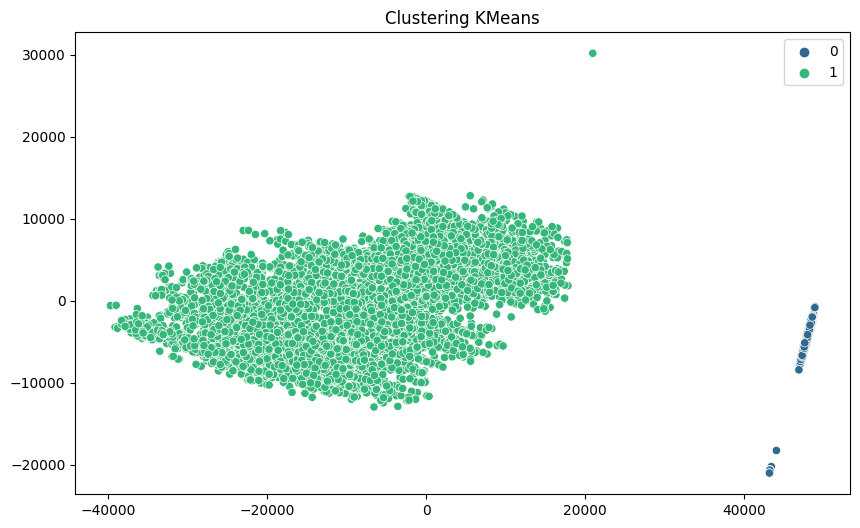

In [29]:
# Modèle de clustering : KMeans

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# PCA pour la réduction de dimensions
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train_full)

# KMeans Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(x_train_full)
clusters = kmeans.predict(x_train_full)

# Visualisation des clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_train_pca[:, 0], y=x_train_pca[:, 1], hue=clusters, palette='viridis')
plt.title("Clustering KMeans")
plt.show()

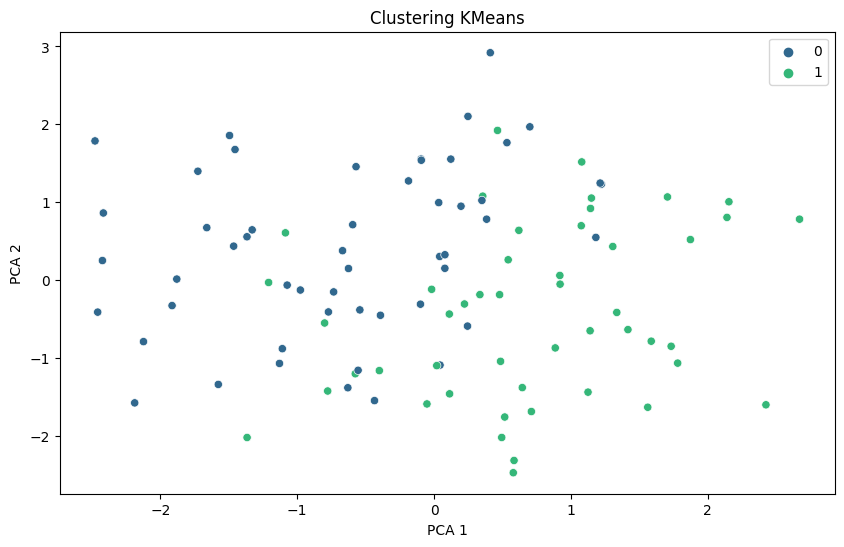

In [30]:
#Tests sur un jeu de données fictifs

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Exemple de données fictives pour tester
import numpy as np
np.random.seed(42)
x_train_t = np.random.rand(100, 9)  # Simule un dataset de 100 échantillons avec 9 features

# Normalisation des données
scaler_t = StandardScaler()
x_train_scaled_t= scaler_t.fit_transform(x_train_t)

# Réduction de dimensions avec PCA
pca = PCA(n_components=2)
x_train_pca_t = pca.fit_transform(x_train_scaled_t)

# KMeans Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(x_train_scaled_t)

# Visualisation des clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_train_pca_t[:, 0], y=x_train_pca_t[:, 1], hue=clusters, palette='viridis')
plt.title("Clustering KMeans")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


## 6) Modèle supervisé

In [31]:
# Modèles SVM et RF

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train_full, y_train_binary_full)
y_pred_rf = rf_model.predict(x_train_full)
weighted_acc_rf = weighted_accuracy(y_train_full, y_pred_rf, y_train_full)

# SVM
svm_model = SVC(random_state=42)
svm_model.fit(x_train_full, y_train_binary_full)
y_pred_svm = svm_model.predict(x_train_full)
weighted_acc_svm = weighted_accuracy(y_train_full, y_pred_svm, y_train_full)

# Comparaison des performances
print("Random Forest Weighted Accuracy:", weighted_acc_rf)
print("SVM Weighted Accuracy:", weighted_acc_svm)

Random Forest Weighted Accuracy: 0.5203756715367432
SVM Weighted Accuracy: 0.29075110417742295


## 7) Intérprétation des modèles BUG

In [34]:
import shap
from lime.lime_tabular import LimeTabularExplainer

# SHAP pour le modèle Random Forest
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(x_train_full)

# Résumé graphique SHAP
shap.summary_plot(shap_values_rf[1], x_train_full)

# LIME pour le modèle Random Forest
lime_explainer_rf = LimeTabularExplainer(x_train_full.values, training_labels=y_train_binary_full.values, feature_names=x_train_full.columns, discretize_continuous=True)
lime_exp_rf = lime_explainer_rf.explain_instance(x_train_full.iloc[0].values, rf_model.predict_proba, num_features=10)
lime_exp_rf.show_in_notebook()

ModuleNotFoundError: No module named 'lime'

## 8) Modèle de Deep Learning

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Création du modèle de Deep Learning
dl_model = Sequential([
    Dense(64, activation='relu', input_dim=x_train_full.shape[1]),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilation du modèle
dl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
dl_model.fit(x_train_full, y_train_binary_full, epochs=20, batch_size=32, validation_split=0.2)

# Prédiction et évaluation
y_pred_dl = (dl_model.predict(x_train_full) > 0.5).astype(int)
y_pred_dl = y_pred_dl.flatten()
weighted_acc_dl = weighted_accuracy(y_train_full, y_pred_dl, y_train_full)

print("Deep Learning Model Weighted Accuracy:", weighted_acc_dl)




Epoch 1/20


213/213 [==============================] - 3s 5ms/step - loss: 775.2787 - accuracy: 0.4948 - val_loss: 115.7067 - val_accuracy: 0.5156
Epoch 2/20
213/213 [==============================] - 1s 3ms/step - loss: 232.2117 - accuracy: 0.4998 - val_loss: 47.7432 - val_accuracy: 0.5115
Epoch 3/20
213/213 [==============================] - 1s 4ms/step - loss: 118.6417 - accuracy: 0.4883 - val_loss: 23.2705 - val_accuracy: 0.5250
Epoch 4/20
213/213 [==============================] - 1s 4ms/step - loss: 48.9594 - accuracy: 0.5045 - val_loss: 20.7930 - val_accuracy: 0.5056
Epoch 5/20
213/213 [==============================] - 1s 3ms/step - loss: 29.0329 - accuracy: 0.4987 - val_loss: 22.0663 - val_accuracy: 0.5080
Epoch 6/20
213/213 [==============================] - 1s 3ms/step - loss: 21.9040 - accuracy: 0.4973 - val_loss: 21.8366 - val_accuracy: 0.5109
Epoch 7/20
213/213 [==============================] - 1s 3ms/step - loss: 18.4488 - accuracy: 0.5023 - val_loss: 10.2979 - val_

## 9) Comparaison des résultats

In [ ]:
# Comparaison des modèles
model_performance = {
    'Baseline (Logistic Regression)': weighted_acc_baseline,
    'Random Forest': weighted_acc_rf,
    'SVM': weighted_acc_svm,
    #'Deep Learning': weighted_acc_dl
}

for model, score in model_performance.items():
    print(f"{model}: {score:.4f}")

Baseline (Logistic Regression): 0.3263
Random Forest: 0.5204
SVM: 0.2908
